In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0, '/content/drive/My Drive/PotraitNet')

Mounted at /content/drive


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torchvision
import numpy as np
from matplotlib import pyplot as plt
import shutil
from easydict import EasyDict as edict
from dataset_preprocessor import Human
from Losses import FocalLoss
from PotraitNet import PotraitNet
import os
import cv2
import warnings
warnings.filterwarnings("ignore")

In [20]:
args = edict()
args.batchsize = 64
args.lr = 0.001
args.momentum = 0.9
args.weightdecay = 5e-4
args.printfreq = 100
args.savefreq = 1000
args.workers = 8
args.model_root = "/content/drive/My Drive/PotraitNet/data/model/"
args.input_height = args.input_width = 224

# the probability to set empty prior channel, default=0.5
args.prior_prob = 0.5

# the weight of boundary auxiliary loss, default=0.1
args.edgeRatio = 0.1

# temperature in consistency constraint loss, default=1
args.temperature = 1

# the weight of consistency constraint loss, default=2
args.alpha = 2

# input normalization parameters
args.padding_color = 128
args.img_scale = 1
# BGR order
args.img_mean = [103.94, 116.78, 123.68]
args.img_val = [0.017, 0.017, 0.017]

args.resume_train = True

Compute the train dataset

In [21]:
args.istrain = True
dataset_train = Human(args)
print ("image number in training: ", len(dataset_train))
dataLoader_train = torch.utils.data.DataLoader(dataset_train, batch_size=args.batchsize,
                                                   shuffle=True, num_workers= args.workers)

image number in training:  1347


Compute the Test Dataset

In [22]:
args.istrain = False
dataset_test = Human(args)
print ("image number in testing: ", len(dataset_test))
dataLoader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1,
                                                  shuffle=False, num_workers=args.workers)

image number in testing:  260


Compute the Final Evaluation Dataset

In [23]:
args.istrain = False
dataset_eval = Human(args, eval=True)
print ("image number in evaluation: ", len(dataset_eval))
dataLoader_eval = torch.utils.data.DataLoader(dataset_eval, batch_size=1,
                                                  shuffle=False, num_workers=args.workers)

image number in evaluation:  129


import the model

In [24]:
netmodel = PotraitNet(channelRatio=1.0,
                      minChannel=16).cuda()

In [25]:

def get_parameters(model, args):
    lr_0 = [value for key, value in model.named_parameters() if 'deconv' in key]
    lr_1 = [value for key, value in model.named_parameters() if 'deconv' not in key]

    params = [
        {'params': lr_0, 'lr': 0.0},
        {'params': lr_1, 'lr': args.lr}
    ]

    return params, [0.0, 1.0]

params, multiple = get_parameters(netmodel, args)
optimizer = torch.optim.Adam(params, args.lr, weight_decay=args.weightdecay)

In [26]:
def save_checkpoint(state, is_best, root, filename='checkpoint.pth.tar'):
    torch.save(state, root+filename)
    if is_best:
        shutil.copyfile(root+filename, root+'model_best.pth.tar')

In [27]:
def adjust_learning_rate(optimizer, epoch, args, multiple):
    """Sets the learning rate to the initial LR decayed by 0.95 every 20 epochs"""
    lr = args.lr * (0.95 ** (epoch // 20))
    for i, param_group in enumerate(optimizer.param_groups):
        param_group['lr'] = lr * multiple[i]
    pass

In [28]:
def loss_KL(student_outputs, teacher_outputs, T):
    """
    Code referenced from:
    https://github.com/peterliht/knowledge-distillation-pytorch/blob/master/model/net.py

    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha
    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! See Issue #2
    """
    KD_loss = nn.KLDivLoss()(F.log_softmax(student_outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * T * T
    return KD_loss

In [29]:
def train(dataLoader, netmodel, optimizer, epoch, exp_args):
    netmodel.train() # switch to train mode

    loss_Softmax = nn.CrossEntropyLoss(ignore_index=255) # mask loss
    # in our experiments, focalloss is better than l2 loss
    loss_Focalloss = FocalLoss(gamma=2) # boundary loss

    for i, (input_ori, input, edge, mask) in enumerate(dataLoader):
        input_ori_var, input_var, edge_var, mask_var = Variable(input_ori.cuda()), Variable(input.cuda()), Variable(edge.cuda()), Variable(mask.cuda())

        output_mask, output_edge = netmodel(input_var)
        # loss given by the difference between the computed mask on the normal image and the real mask
        loss_mask = loss_Softmax(output_mask, mask_var)
        # loss given by the difference between the computed edge on the normal image and the real edge
        loss_edge = loss_Focalloss(output_edge, edge_var) * exp_args.edgeRatio
        # total loss
        output_mask_ori, output_edge_ori = netmodel(input_ori_var)
        # loss given by the difference between the computed mask on the enhanced image and the real mask
        loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
        # loss given by the difference between the computed edge on the enhanced image and the real edge
        loss_edge_ori = loss_Focalloss(output_edge_ori, edge_var) * exp_args.edgeRatio

        # consistency constraint loss: KL distance (better than L2 distance)
        # soft label loss
        # loss given by the difference between the computed mask on the enhanced image and computed mask on the normal image
        loss_stability_mask = loss_KL(output_mask,
                                        Variable(output_mask_ori.data, requires_grad = False),
                                        exp_args.temperature) * exp_args.alpha
        # loss given by the difference between the computed edge on the enhanced image and computed edge on the normal image
        loss_stability_edge = loss_KL(output_edge,
                                        Variable(output_edge_ori.data, requires_grad = False),
                                        exp_args.temperature) * exp_args.alpha * exp_args.edgeRatio

        # total loss
        loss = loss_mask + loss_mask_ori + loss_edge + loss_edge_ori + loss_stability_mask + loss_stability_edge

        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print the value of the last training loss
        if i == len(dataLoader) - 1:
            print(f"Epoch {epoch}:\t Lr-other: {optimizer.param_groups[1]['lr']}\t loss: {loss.data}")

In [30]:
def calcIOU(img, mask):
    # compute the intersection
    intersection = np.logical_and(img, mask)
    # compute the union
    union = np.logical_or(img, mask)
    # compute iou (in case union is empty union = 1)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 1.0
    return iou

In [31]:
def test(dataLoader, netmodel, optimizer, epoch, exp_args):
    # switch to eval mode
    netmodel.eval()

    loss_Softmax = nn.CrossEntropyLoss(ignore_index=255) # mask loss
    loss_Focalloss = FocalLoss(gamma=2) # edge loss

    softmax = nn.Softmax(dim=1)
    iou = 0

    for i, (input_ori, input, edge, mask) in enumerate(dataLoader):
        input_var, mask_var = Variable(input.cuda()), Variable(mask.cuda())

        output_mask, output_edge = netmodel(input_var)

        prob = softmax(output_mask)[0,1,:,:]
        pred = prob.data.cpu().numpy()
        pred = np.where(pred > 0.5, 1, 0)
        iou += calcIOU(pred, mask_var[0].data.cpu().numpy())

    return 1-iou/len(dataLoader)

In [32]:
minLoss = 10000
gap = 0
loss_history = []
if args.resume_train:
    bestModelFile = os.path.join(args.model_root, 'model_best.pth.tar')
    if os.path.isfile(bestModelFile):
        checkpoint = torch.load(bestModelFile)
        netmodel.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        gap = checkpoint['epoch']
        minLoss = checkpoint['minLoss']
        loss_history = checkpoint['loss_history']
        print("=> loaded checkpoint '{}' (epoch {})".format(bestModelFile, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(bestModelFile))

=> loaded checkpoint '/content/drive/My Drive/PotraitNet/data/model/model_best.pth.tar' (epoch 477)


In [33]:
for epoch in range(gap, 1000):
    adjust_learning_rate(optimizer, epoch, args, multiple)

    train(dataLoader_train, netmodel, optimizer, epoch, args)

    # computing the loss on test set to verify if we need to
    loss = test(dataLoader_test, netmodel, optimizer, epoch, args)
    print (f"epoch {epoch} loss: {loss}, minimum epochs loss: {minLoss}")

    # saving the progress
    is_best = loss < minLoss
    minLoss = loss if is_best else minLoss
    loss_history.append(loss)
    save_checkpoint({
        'epoch': epoch+1,
        'minLoss': minLoss,
        'state_dict': netmodel.state_dict(),
        'optimizer' : optimizer.state_dict(),
        'loss_history': loss_history
        }, is_best, args.model_root)

Epoch 477:	 Lr-other: 0.00030735686772502356	 loss: 0.08397947251796722
epoch 477 loss: 0.04607264460894023, minimum epochs loss: 0.046374260610707374
Epoch 478:	 Lr-other: 0.00030735686772502356	 loss: 0.14989447593688965
epoch 478 loss: 0.04567408206077683, minimum epochs loss: 0.04607264460894023
Epoch 479:	 Lr-other: 0.00030735686772502356	 loss: 0.15710218250751495
epoch 479 loss: 0.04660616238536508, minimum epochs loss: 0.04567408206077683
Epoch 480:	 Lr-other: 0.0002919890243387724	 loss: 0.2383577674627304
epoch 480 loss: 0.04521475944740727, minimum epochs loss: 0.04567408206077683
Epoch 481:	 Lr-other: 0.0002919890243387724	 loss: 0.39551252126693726
epoch 481 loss: 0.047462517096966694, minimum epochs loss: 0.04521475944740727
Epoch 482:	 Lr-other: 0.0002919890243387724	 loss: 0.49713507294654846
epoch 482 loss: 0.04633930505028494, minimum epochs loss: 0.04521475944740727
Epoch 483:	 Lr-other: 0.0002919890243387724	 loss: 0.14515744149684906
epoch 483 loss: 0.0500486136082

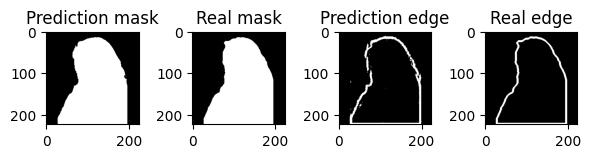

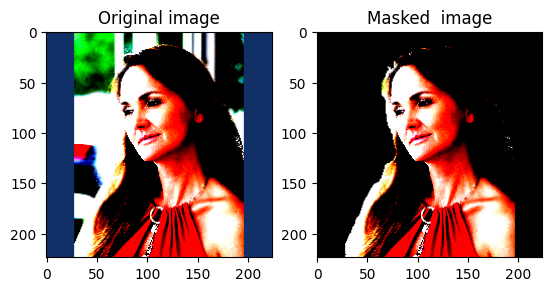

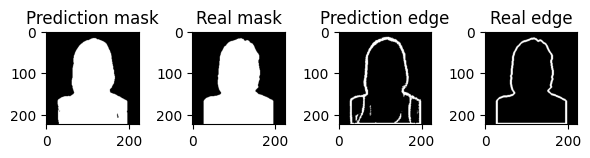

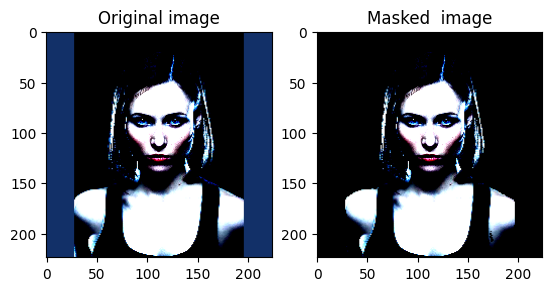

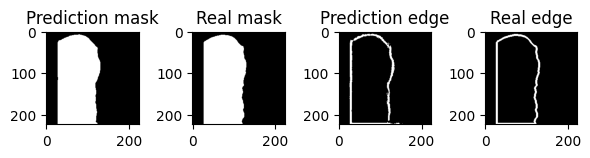

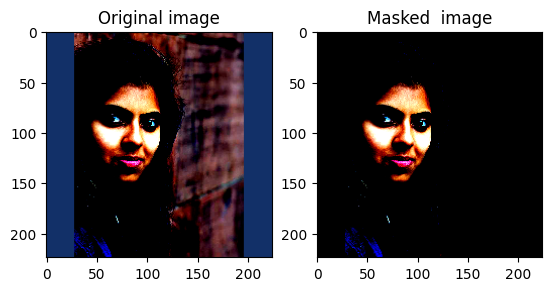

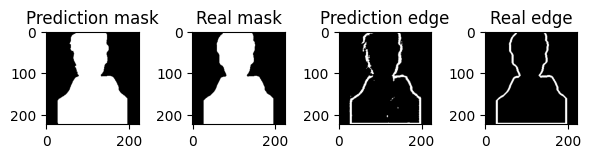

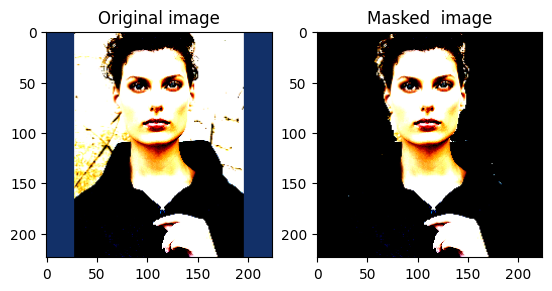

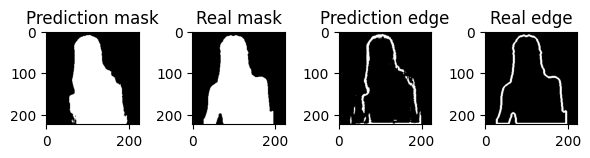

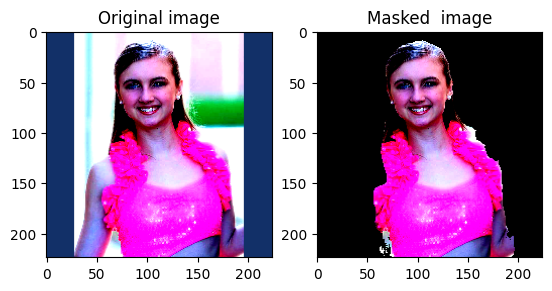

In [57]:
def add_plot(img, n_plot, tot_plot, cmap=None, title=""):
    plt.subplot(1, tot_plot, n_plot)
    plt.imshow(img, cmap=cmap)
    plt.title(title)

def evaluate(dataLoader, netmodel):
    # switch to eval mode
    netmodel.eval()

    loss_Softmax = nn.CrossEntropyLoss(ignore_index=255) # mask loss
    loss_Focalloss = FocalLoss(gamma=2) # edge loss

    softmax = nn.Softmax(dim=1)
    iou = 0

    for i, (input_ori, input, edge, mask) in enumerate(dataLoader):
        if index <= i < index + 5:
            input_ori_var = Variable(input_ori.cuda())

            output_mask, output_edge = netmodel(input_ori_var)

            prob = softmax(output_mask)[0,1,:,:]
            pred = prob.data.cpu().numpy()
            pred = np.where(pred > 0.5, 1, 0)

            prob = softmax(output_edge)[0,1,:,:]
            pred_edge = prob.data.cpu().numpy()
            pred_edge = np.where(pred_edge > 0.4, 1, 0)

            plt.figure(figsize=(6, 3))

            # Plot the first image on the left subplot
            add_plot(pred, 1, 4, "gray", "Prediction mask")

            # Plot the second image on the right subplot
            add_plot(mask[0], 2, 4, "gray", "Real mask")

            add_plot(pred_edge, 3, 4, "gray", "Prediction edge")

            add_plot(edge[0], 4, 4, "gray", "Real edge")

            # For the spacing between the subplots
            plt.tight_layout()

            # Show the plot
            plt.show()

            add_plot(cv2.cvtColor(input_ori.squeeze().permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB), 1, 2, title="Original image")
            masked_image = cv2.cvtColor((input_ori.squeeze()*pred).permute(1, 2, 0).numpy().astype('float32'), cv2.COLOR_BGR2RGB)
            add_plot(masked_image, 2, 2, title="Masked  image")

            # Show the plot
            plt.show()

# index to choose which 5 image to print (sequentially)
index = 35
evaluate(dataLoader_eval, netmodel)

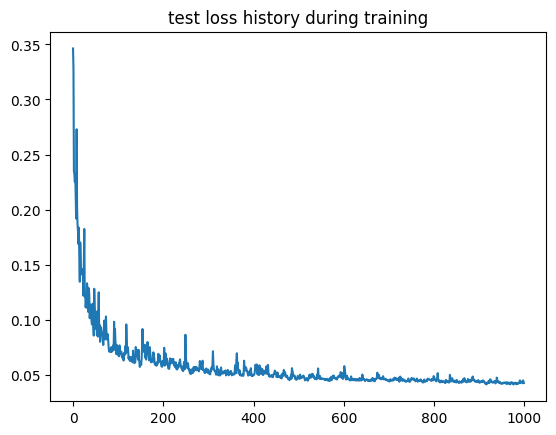

In [47]:
plt.title("test loss history during training")
plt.plot(range(len(loss_history)), loss_history)
plt.show()

In [48]:
print("mean iou: ", 1 - test(dataLoader_eval, netmodel, optimizer, 0, args))

mean iou:  0.9497071305106083
